# Project Overview

The Model Fitness gym chain is developing a data-driven strategy to improve customer engagement and retention.

One of the most common challenges faced by gyms—and many subscription-based services—is customer churn. Identifying when a customer has truly left is not always straightforward. While churn can be measured through explicit actions such as contract cancellations or non-renewals, in many cases customers disengage gradually without a clear signal.

Churn indicators vary across industries. For example, an online retail customer who purchases infrequently but consistently may still be considered active. In contrast, if a user stops interacting with a platform that is updated daily for several weeks, this may indicate disengagement and potential churn.

In the context of a gym, it is reasonable to consider a customer churned if they stop attending for a full month. While exceptions exist—such as temporary travel—these cases are relatively uncommon. Typically, when a customer joins, attends for a period, and then stops visiting altogether, the likelihood of return is low.

To address customer churn, Model Fitness has digitized multiple customer profiles. The objective of this project is to analyze this data and develop a customer retention strategy based on analytical insights.

## Project Objectives

- Predict the probability of customer churn for the following month.
- Create profiles of typical customers by identifying and describing key customer segments.
- Analyze the factors that have the greatest impact on churn.
- Draw actionable conclusions and provide recommendations to improve customer retention, including:
  - Identifying target customer groups.
  - Proposing measures to reduce churn.
  - Highlighting additional patterns related to customer behavior and engagement.

## Step 1. Data Loading

Model Fitness provided CSV files containing customer churn data for a specific month, along with customer information from the previous month. The dataset includes the following fields:

### Current Dataset Fields
- **Churn** — indicates whether the customer churned during the analyzed month.

### Customer Information from the Previous Month
- **gender**
- **Near_Location** — whether the customer lives or works near the gym location.
- **Partner** — whether the customer works for a partner company (employees of partner companies receive discounts; in these cases, the gym stores employer information).
- **Promo_friends** — whether the customer originally signed up through a “bring a friend” promotion (using a referral code during the first payment).
- **Phone** — whether the customer provided a phone number.
- **Age**
- **Lifetime** — the number of months since the customer first joined the gym.

### Visit, Purchase, and Membership Status Data
- **Contract_period** — contract length (1 month, 3 months, 6 months, or 1 year).
- **Month_to_end_contract** — number of months remaining until contract expiration.
- **Group_visits** — whether the customer participates in group sessions.
- **Avg_class_frequency_total** — average number of visits per week over the customer’s lifetime.
- **Avg_class_frequency_current_month** — average number of visits per week during the current month.
- **Avg_additional_charges_total** — total amount spent on additional gym services (café, sports products, cosmetics, massages, etc.).

**Dataset path:** `/datasets/gym_churn_us.csv`

In [10]:
# import libraries
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro, mannwhitneyu, norm
from scipy.cluster.hierarchy import dendrogram, linkage
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import gower
# scikit-learn libraries
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, silhouette_score
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn_extra.cluster import KMedoids
sns.set(style="whitegrid")

In [12]:
# Load dataset and create DataFrame
mf = pd.read_csv('/Users/stephanethions/Documents/VirtualEnv/gym_churn_us.csv')

# Convert the 'Month_to_end_contract' variable to integer
mf['Month_to_end_contract'] = mf['Month_to_end_contract'].astype(int)

# Review basic DataFrame information
mf.info()
print()
display(mf.describe())
print()
display(mf.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   int64  
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1,3,1.113884,1.120078,0


## Exploratory Data Analysis (EDA)

The following exploratory analysis was conducted to better understand the dataset and identify patterns related to customer churn:

- Examine the dataset for missing values.
- Analyze summary statistics, including mean and standard deviation, using the `describe()` method.
- Compare average feature values between two groups:
  - Customers who churned
  - Customers who remained active  
  (using the `groupby()` method)
- Visualize feature distributions and bar histograms for churned vs. retained customers.
- Create and display a correlation matrix to identify relationships between variables.

### Key Initial Statistics

- **Average age**: 29.2 years (ranging from 18 to 41 years).
- **Churn rate**: Approximately 26.5% of users have churned.
- **Contract period**: The average contract length is 4.7 months, while the median is only 1 month, indicating a strong skew toward very short-term contracts.
- **Class attendance frequency**:
  - Lifetime average: ~1.88 classes per week.
  - Current month average: ~1.76 classes per week.  
  This suggests relatively low overall engagement.
- **Additional charges**: The average spend on additional services is approximately $146, with values reaching up to $550.
- **Gender distribution**: The split between male and female customers is relatively balanced.
- **Proximity to the gym**: Around 84% of users live or work near the gym.
- **Partner program**: Slightly less than half of the users are enrolled in the partner program.
- **Friend referral promotion**: Approximately 30% of users joined through friend referral promotions.
- **Phone number provided**: Over 90% of users supplied a phone number.
- **Customer lifetime**:
  - Average duration of approximately 3 months.
  - 75% of users remain for less than 5 months.
  - A small number of outliers have remained active for more than 30 months.

,No churn,Churn
gender,0.510037,0.510839
Near_Location,0.873086,0.768143
Partner,0.534195,0.355325
Promo_friends,0.353522,0.183789
Phone,0.903709,0.902922
Contract_period,5.747193,1.728558
Group_visits,0.464103,0.268615
Age,29.976523,26.989632
Avg_additional_charges_total,158.445715,115.082899
Month_to_end_contract,5.283089,1.662582


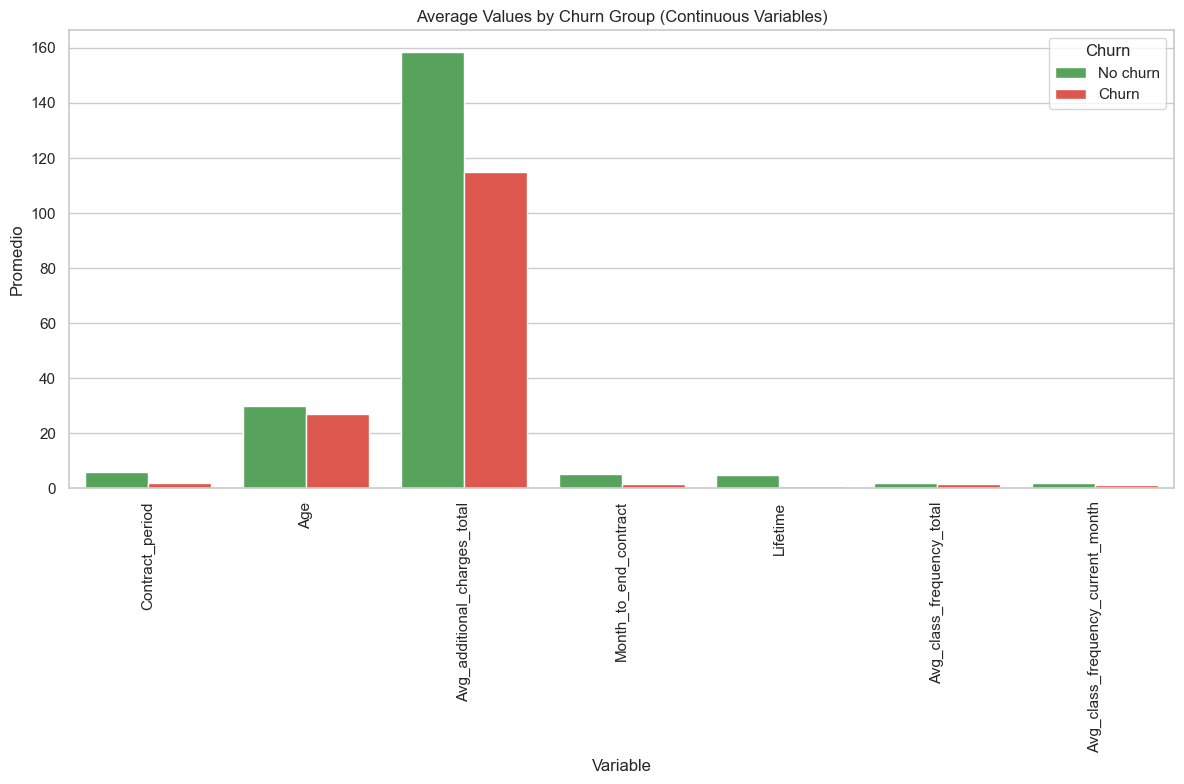

In [14]:
# Split users into churned vs. non-churned groups
group_means = mf.groupby('Churn').mean()
group_means.index = ['No churn', 'Churn']
display(group_means.T)

# Select non-binary features
non_binary_cols = [
    'Contract_period', 
    'Age', 
    'Avg_additional_charges_total', 
    'Month_to_end_contract', 
    'Lifetime', 
    'Avg_class_frequency_total', 
    'Avg_class_frequency_current_month'
]

# Compute mean values by churn group using only non-binary features
group_means_filtered = mf.groupby('Churn')[non_binary_cols].mean()

# Convert data to long format for proper visualization
group_means_long = group_means_filtered.T.reset_index().melt(id_vars='index')
group_means_long.columns = ['Variable', 'Churn', 'Promedio']

# Map churn values to readable labels
group_means_long['Churn'] = group_means_long['Churn'].map({0: 'No churn', 1: 'Churn'})

# Fix color palette
palette = {"No churn": "#4CAF50", "Churn": "#F44336"}

# Plot results
plt.figure(figsize=(12, 8))
sns.barplot(data=group_means_long, x='Variable', y='Promedio', hue='Churn', palette=palette)
plt.title("Average Values by Churn Group (Continuous Variables)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

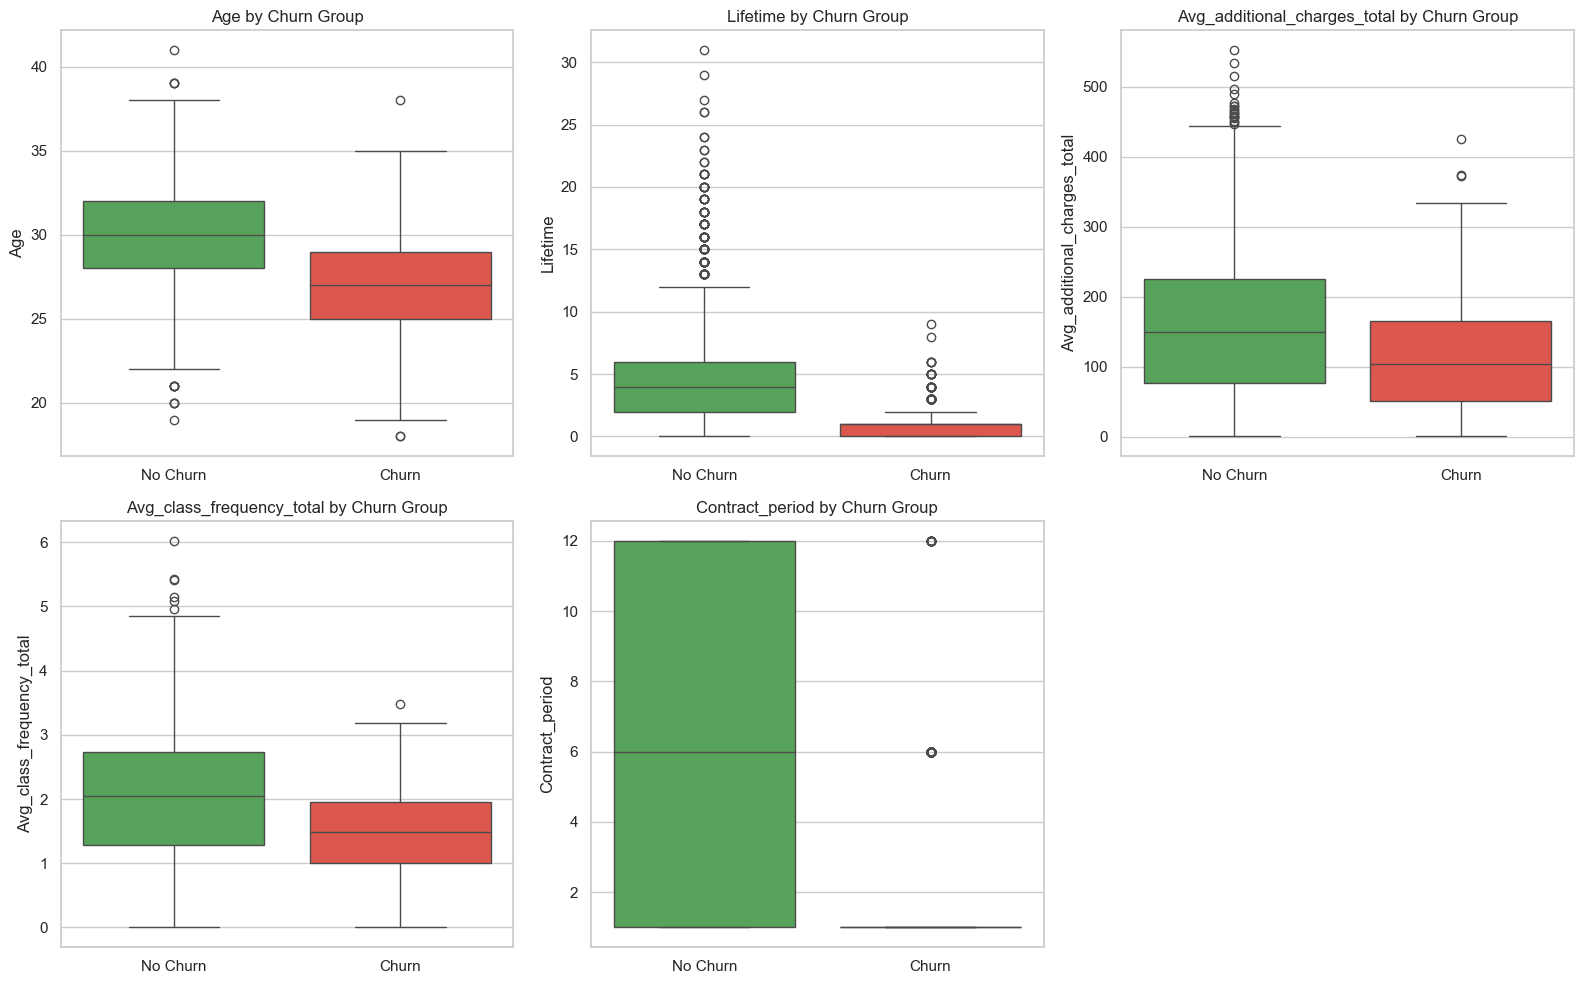

In [16]:
# Define numerical variables to visualize
vars_to_plot = ['Age', 'Lifetime', 'Avg_additional_charges_total', 
                'Avg_class_frequency_total', 'Contract_period']

# Fixed color palette for each churn category
palette_boxplots = {0: "#4CAF50", 1: "#F44336"}  # 0 = No Churn, 1 = Churn

plt.figure(figsize=(16, 10))
for i, col in enumerate(vars_to_plot, 1):
    plt.subplot(2, 3, i)
    ax = sns.boxplot(x='Churn', y=col, data=mf, hue='Churn', palette=palette_boxplots, legend=False)
    ax.set_title(f'{col} by Churn Group')
    ax.set_xlabel('')
    ax.set_ylabel(col)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['No Churn', 'Churn'])
plt.tight_layout()
plt.show()

In [18]:
# Separate age values by churn group
age_churn_0 = mf[mf['Churn'] == 0]['Age']
age_churn_1 = mf[mf['Churn'] == 1]['Age']

# Normality test (Shapiro-Wilk)
stat_0, p_0 = shapiro(age_churn_0)
stat_1, p_1 = shapiro(age_churn_1)

# Display results
print("Shapiro-Wilk test to assess Age distribution by churn group\n")
if p_0 > 0.05:
    print(f"No Churn {p_0:.4f}: Age distribution is normal (fail to reject H0)")
else:
    print(f"No Churn {p_0:.4f}: Age distribution is not normal (reject H0)")

if p_1 > 0.05:
    print(f"Churn Group {p_1:.4f}: Age distribution is normal (fail to reject H0)")
else:
    print(f"Churn Group {p_1:.4f}: Age distribution is not normal (reject H0)")

Shapiro-Wilk test to assess Age distribution by churn group

No Churn 0.0000: Age distribution is not normal (reject H0)
Churn Group 0.0000: Age distribution is not normal (reject H0)


In [19]:
# Mann-Whitney U test (non-parametric)
stat, p = mannwhitneyu(age_churn_0, age_churn_1, alternative='two-sided')

# Z-score calculation (used to compute effect size r)
# Applied only when n1 and n2 > 20 (normal approximation)
n1 = len(age_churn_0)
n2 = len(age_churn_1)
mean_U = n1 * n2 / 2
std_U = np.sqrt(n1 * n2 * (n1 + n2 + 1) / 12)
z = (stat - mean_U) / std_U

# Effect size (r)
r = abs(z) / np.sqrt(n1 + n2)

# Display results
print("Mann-Whitney U test to compare age distributions between churn groups\n")
print(f'U statistic: {stat:.2f}')
print(f'P-value: {p:.4f}')
print(f'Z statistic: {z:.2f}')
print(f'Effect size (r): {r:.3f}')

# Effect size interpretation
if r < 0.1:
    interpret = "negligible"
elif r < 0.3:
    interpret = "small"
elif r < 0.5:
    interpret = "medium"
else:
    interpret = "large"

print(f'Effect size interpretation: {interpret}')

Mann-Whitney U test to compare age distributions between churn groups

U statistic: 2374707.50
P-value: 0.0000
Z statistic: 25.29
Effect size (r): 0.400
Effect size interpretation: medium


### Conclusions from Average Values by Churn Group

Most users—both churned and retained—live close to the gym, with approximately **87%** among retained users versus **76%** among churned users. **This ~11% difference may play a role in customer retention**.

Regarding the **Partner program**, more than **50% of retained users** are enrolled, compared to only **35% of churned users**. This suggests that the discount or incentive provided through this program may have a **positive effect on retention**.

A similar pattern is observed for the **Promo Friends** program: approximately **35% of non-churned users** joined the gym through a referral promotion. This indicates that having a companion or social connection at the gym may contribute to retention, possibly due to a **mutual motivational effect**.

In terms of **customer lifetime**, the difference between groups is substantial. Retained users show an average lifetime of over **5 months**, while churned users average just over **2 months**. This supports the hypothesis that churn tends to occur **very early in the customer lifecycle**.

##### Robust Statistical Analysis of the "Age" Variable

A noticeable difference is observed in **age** between the two groups, with an average of approximately **30 years** for non-churned users and **27 years** for churned users.

Although age is often assumed to follow a normal distribution, **Shapiro–Wilk normality tests** indicate otherwise:

- **No Churn**: p < 0.001 → distribution is not normal  
- **Churn**: p < 0.001 → distribution is not normal  

As a result, a **non-parametric Mann–Whitney U test** was applied, yielding the following results:

- **U statistic**: 2,374,707.5  
- **P-value**: < 0.001  
- **Z statistic**: 25.29  
- **Effect size (r)**: 0.400 → **Medium effect size**

**Conclusion:** Age represents a **relevant factor in customer churn** and should not be ignored in churn modeling.

Additionally, participation in **group classes** shows a meaningful difference between groups: over **45% of retained users** attend group sessions, compared to only **26% of churned users**. This reinforces the hypothesis that **social interaction and collective engagement** may increase customer loyalty.

Finally, while retained users attend on average **one additional class per week** compared to churned users, this difference does not appear strong enough on its own to serve as a primary predictor of churn.

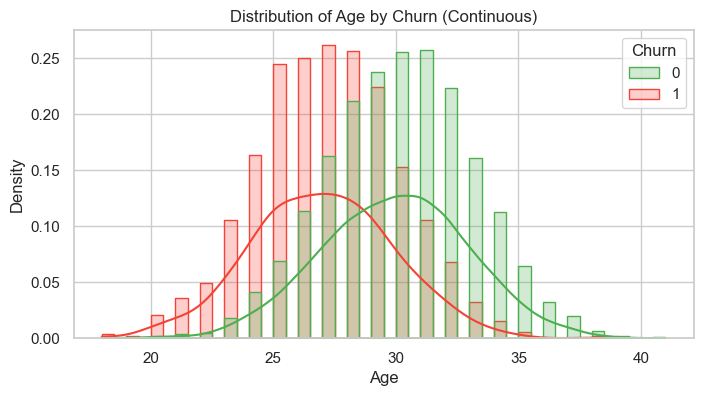

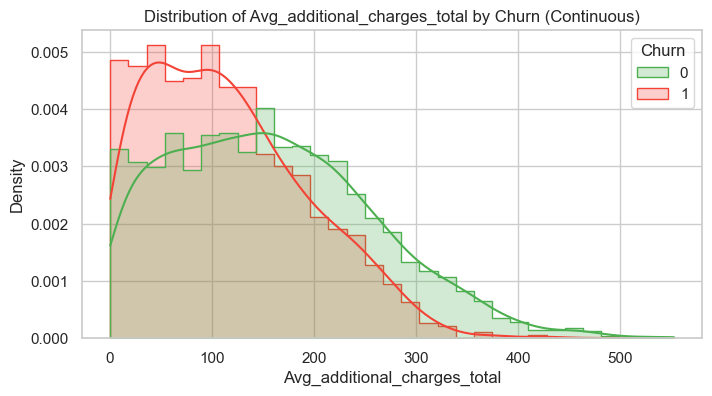

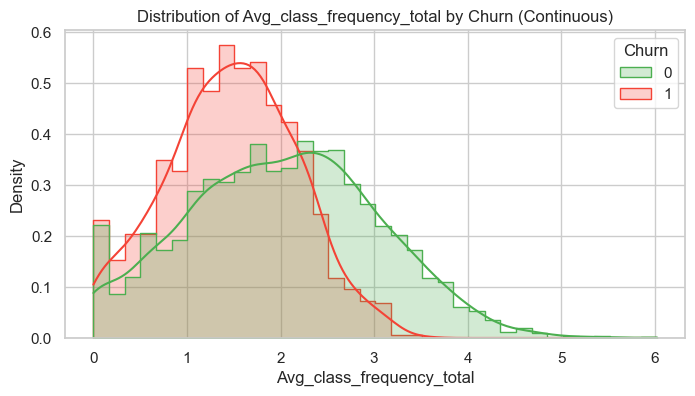

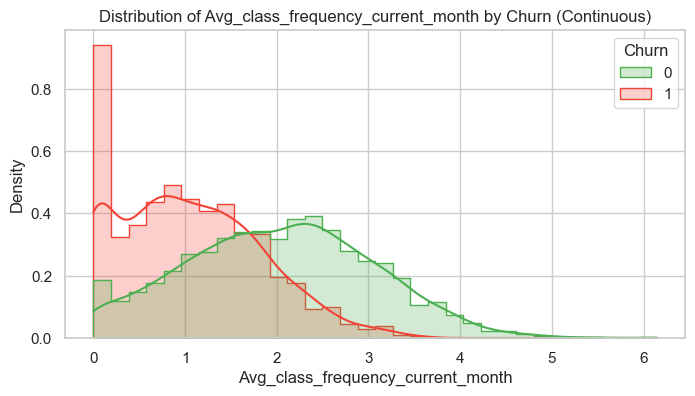

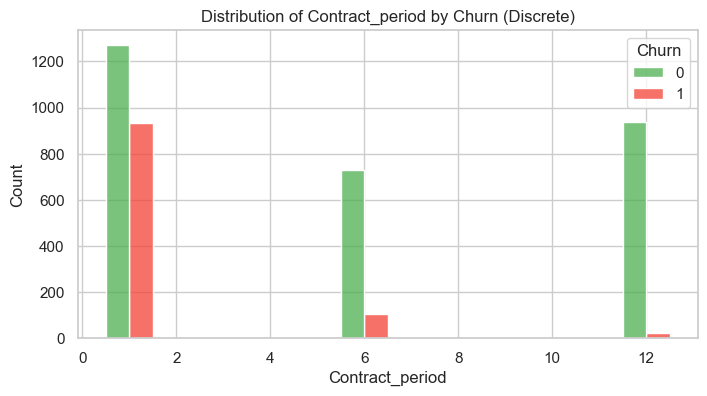

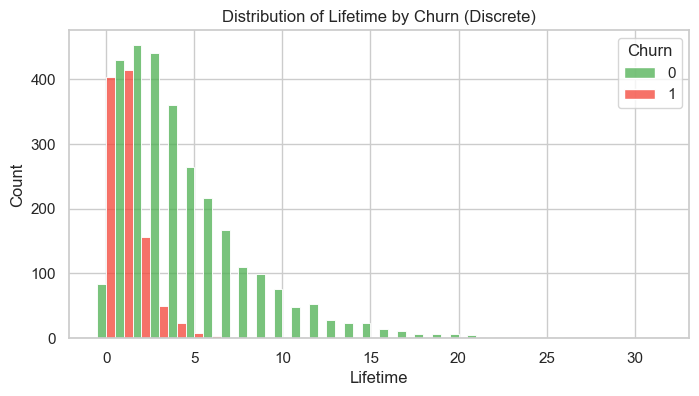

In [20]:
# Custom color palette for churn
palette_corr = {0: '#4CAF50', 1: '#F44336'}

# Group variables by type
continuous_features = [
    'Age', 'Avg_additional_charges_total', 
    'Avg_class_frequency_total', 'Avg_class_frequency_current_month'
]

discrete_features = ['Contract_period', 'Lifetime']

# Continuous variables → Histogram with KDE
for feature in continuous_features:
    plt.figure(figsize=(8, 4))
    sns.histplot(
        data=mf, x=feature, hue='Churn', palette=palette_corr,
        kde=True, element="step", stat="density", common_norm=False
    )
    plt.title(f'Distribution of {feature} by Churn (Continuous)')
    plt.grid(True)
    plt.show()

# Discrete variables → Histogram with discrete bars
for feature in discrete_features:
    plt.figure(figsize=(8, 4))
    sns.histplot(
        data=mf, x=feature, hue='Churn', palette=palette_corr,
        discrete=True, element="bars", stat="count", multiple="dodge"
    )
    plt.title(f'Distribution of {feature} by Churn (Discrete)')
    plt.grid(True)
    plt.show()

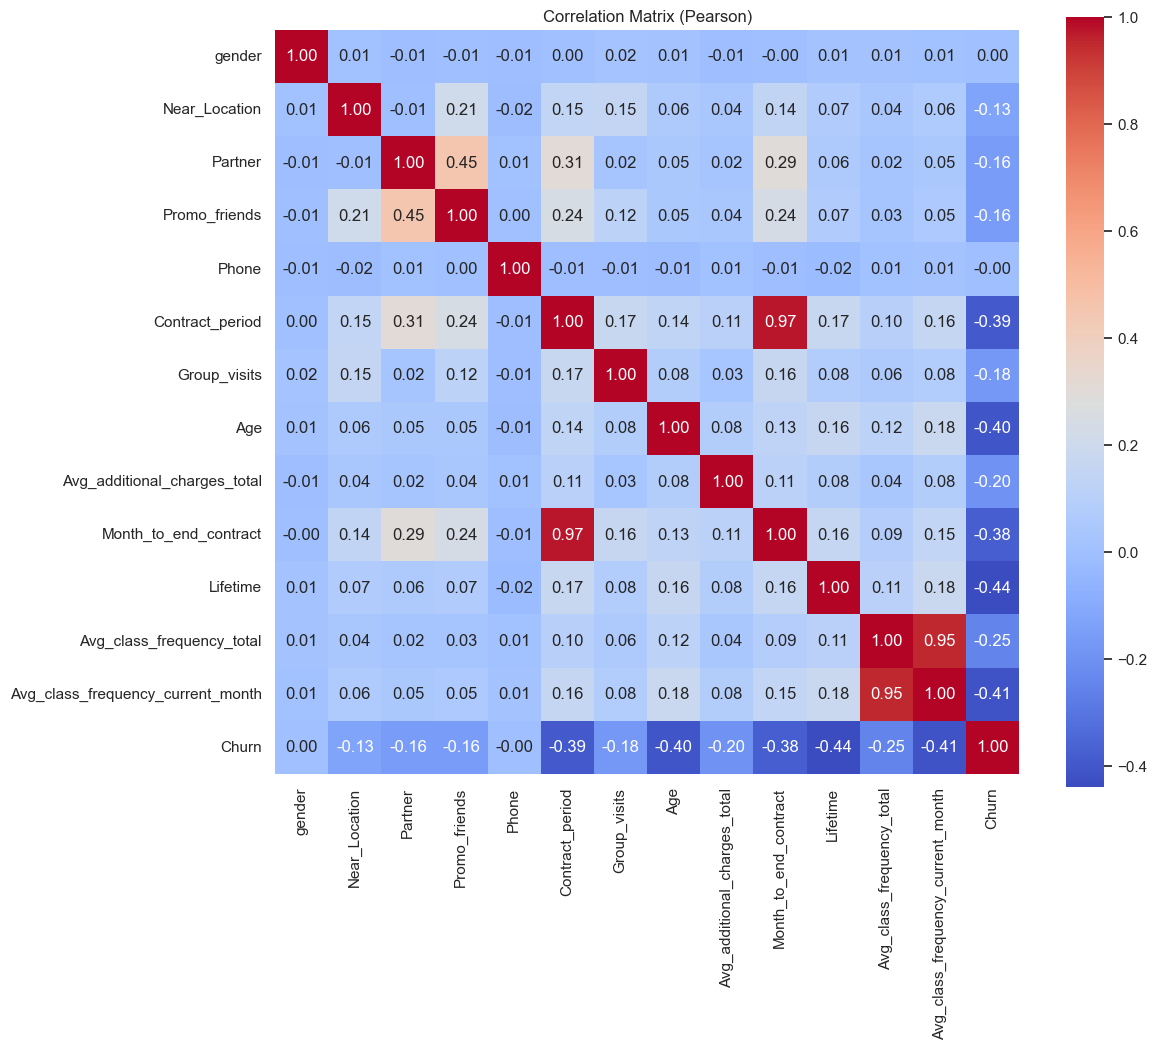

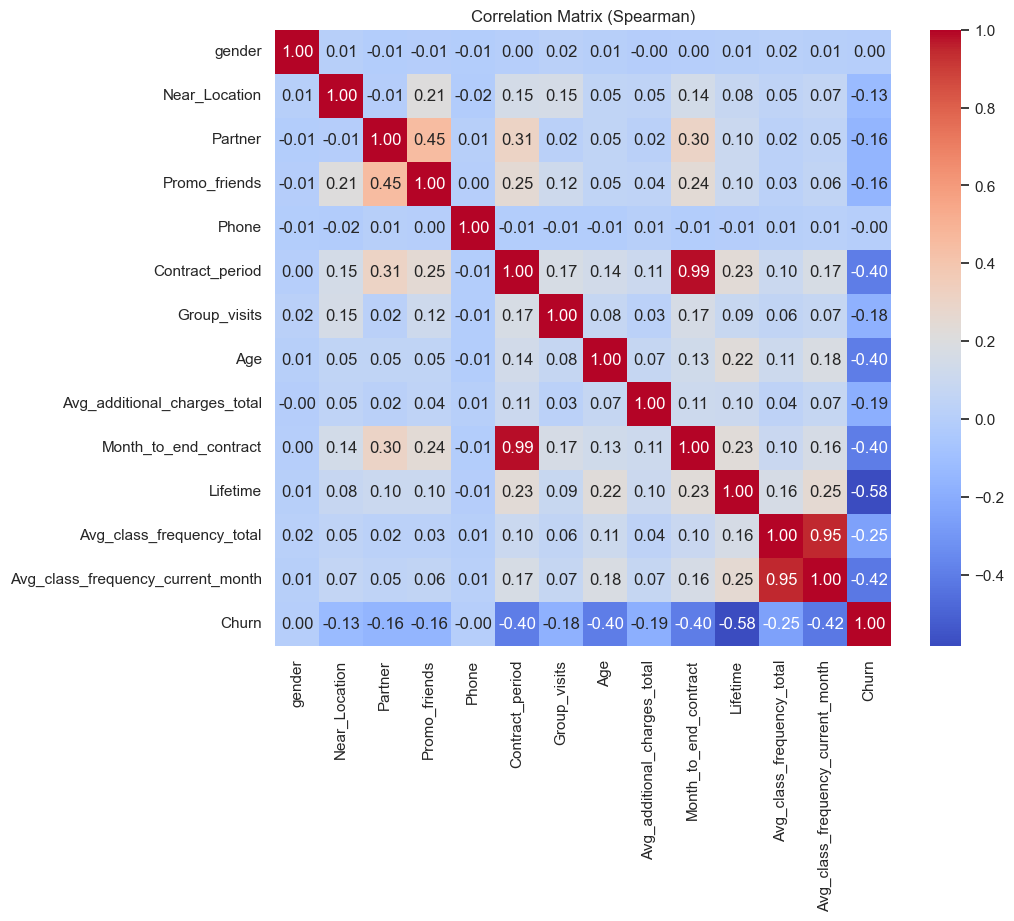

In [21]:
# Correlation matrix
plt.figure(figsize=(12, 10))
corr_matrix = mf.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title('Correlation Matrix (Pearson)')
plt.show()

# Spearman correlation (captures monotonic relationships, ideal for ordinal variables and outliers)
corr_spearman = mf.corr(method='spearman')

plt.figure(figsize=(10, 8))
sns.heatmap(corr_spearman, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title('Correlation Matrix (Spearman)')
plt.show()

In [23]:
# Numerical variables used in the model
numeric_features = [
    'Age', 'Lifetime', 'Contract_period', 'Month_to_end_contract',
    'Avg_additional_charges_total', 'Avg_class_frequency_total',
    'Avg_class_frequency_current_month'
]

# Create a copy of the DataFrame containing only numerical features
X_vif = mf[numeric_features].copy()

# Add constant term (required by statsmodels)
X_vif = sm.add_constant(X_vif)

# Compute VIF for each variable
vif_data = pd.DataFrame()
vif_data['Variable'] = X_vif.columns
vif_data['VIF'] = [
    variance_inflation_factor(X_vif.values, i)
    for i in range(X_vif.shape[1])
]

# Display results sorted by VIF
vif_data.sort_values(by='VIF', ascending=False)

,Variable,VIF
0,const,90.002194
3,Contract_period,18.967318
4,Month_to_end_contract,18.860789
7,Avg_class_frequency_current_month,12.490664
6,Avg_class_frequency_total,11.929293
2,Lifetime,1.104620
1,Age,1.088797
5,Avg_additional_charges_total,1.028028


#### Conclusions from Distribution and Correlation Analysis

The distribution analysis reveals clear behavioral differences between user groups based on their churn status (`Churn`):

- **Contract Period** and **Lifetime** show visibly skewed distributions between retained and churned users. Active users tend to have longer contracts and longer engagement histories, while most churned users leave within the first few months, confirming a pattern of **early-stage churn**.

- For **Additional Charges**, churned users tend to accumulate lower total spending on extra services. This may indicate lower participation in complementary offerings such as additional classes or gym products, reflecting **lower engagement or commitment**.

- **Total and Monthly Class Frequency** display similar distribution shapes across groups, with only slight density differences. Retained users tend to attend classes slightly more frequently, though not with a margin as pronounced as in other variables. This suggests that **class frequency alone does not determine churn**, but may reinforce retention when combined with other factors.

- Regarding **Age**, the analysis shows a **statistically significant difference between groups**. Retained users tend to be older, with a stronger concentration around 30 years of age, while churned users are more concentrated around age 27. **This pattern is supported both by the Mann–Whitney U test**, which detected a significant difference between distributions, and by the histograms, which clearly show a rightward shift in the density curve for the non-churn group.

The **correlation heatmap** reinforces several of these findings. Moderate correlations were observed between:

- `Churn` and **Lifetime** (negative), confirming that longer tenure is associated with a lower probability of churn.
- `Churn` and **Contract Period**, as well as **Partner** and **Promo Friends**, suggesting that affiliation programs and social connections are negatively correlated with churn.

In contrast, binary variables such as **Gender** and **Phone** did not exhibit meaningful correlations with the target variable (`Churn`), indicating minimal or no impact on retention.

Taken together, these observations support the hypothesis that **customer tenure, early engagement, and social integration** are key drivers for predicting and reducing membership churn.

In addition to correlation analysis, **multicollinearity among explanatory variables was evaluated using the Variance Inflation Factor (VIF)**. This metric quantifies how much the variance of estimated regression coefficients increases due to collinearity among predictors. In general, VIF values above 10 are considered problematic, as they indicate significant redundancy and can lead to model instability, particularly in regression-based models such as logistic regression.

In this case, **high VIF values were detected for two variable pairs previously identified as redundant**: on one hand, `Avg_class_frequency_total` and `Avg_class_frequency_current_month`, and on the other, `Contract_period` and `Month_to_end_contract`. Both pairs exhibit correlations above 0.85 and VIF values greater than 15. Since each pair captures essentially the same underlying concept from slightly different perspectives (cumulative vs. monthly frequency, contracted duration vs. remaining time), a conservative approach was adopted by removing one variable from each pair. **We retained `Avg_class_frequency_total` and `Contract_period` due to their greater stability and interpretability.** This refinement reduces redundancy without significant information loss, thereby improving the robustness and performance of the final model.

## Step 3. Build a Model to Predict Customer Churn

Develop a binary classification model where the target variable represents whether a customer churns in the following month.

##### Data preparation and modeling steps:
- Split the data into training and validation sets using the `train_test_split()` function.
- Train the model on the training set using two approaches:
  - Logistic Regression  
  - Random Forest
- Evaluate **accuracy**, **precision**, and **recall** for both models using the validation set.
- Use these metrics to compare model performance and determine which model produces better results.

*Note: Remember to specify the `random_state` parameter when splitting the data and when defining the models to ensure reproducibility.*

In [30]:
# Feature variables and target (excluding 'Gender', 'Phone', and highly collinear variables)
features = [
    'Age', 'Lifetime', 'Contract_period',
    'Avg_additional_charges_total', 'Avg_class_frequency_total',
    'Near_Location', 'Partner', 'Promo_friends', 'Group_visits'
]

X = mf[features]
y = mf['Churn']

# Stratified data split (to preserve class proportions in train and test sets)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Scale numerical features only
cols_to_scale = [
    'Age', 'Lifetime', 'Contract_period',
    'Avg_additional_charges_total', 'Avg_class_frequency_total'
]

scaler = StandardScaler()
X_train_st = X_train.copy()
X_test_st = X_test.copy()

X_train_st[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])
X_test_st[cols_to_scale] = scaler.transform(X_test[cols_to_scale])

# 1. Logistic Regression model
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train_st, y_train)

# Standard binary prediction (default threshold = 0.5)
y_pred_lr = lr_model.predict(X_test_st)

print("Logistic Regression (default threshold = 0.5)")
print(confusion_matrix(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))

# Predicted probabilities for ROC-AUC and threshold tuning
y_proba_lr = lr_model.predict_proba(X_test_st)[:, 1]
roc_auc = roc_auc_score(y_test, y_proba_lr)
print("ROC AUC (Logistic Regression):", round(roc_auc, 3))

# Threshold adjustment to improve recall (e.g., threshold = 0.35)
threshold = 0.35
y_pred_lr_adjusted = (y_proba_lr >= threshold).astype(int)

print(f"\nLogistic Regression (adjusted threshold = {threshold})")
print(confusion_matrix(y_test, y_pred_lr_adjusted))
print(classification_report(y_test, y_pred_lr_adjusted))

Logistic Regression (default threshold = 0.5)
[[554  34]
 [ 44 168]]
              precision    recall  f1-score   support

           0       0.93      0.94      0.93       588
           1       0.83      0.79      0.81       212

    accuracy                           0.90       800
   macro avg       0.88      0.87      0.87       800
weighted avg       0.90      0.90      0.90       800

ROC AUC (Logistic Regression): 0.957

Logistic Regression (adjusted threshold = 0.35)
[[536  52]
 [ 29 183]]
              precision    recall  f1-score   support

           0       0.95      0.91      0.93       588
           1       0.78      0.86      0.82       212

    accuracy                           0.90       800
   macro avg       0.86      0.89      0.87       800
weighted avg       0.90      0.90      0.90       800



In [25]:
# Define the base model
tree = DecisionTreeClassifier(random_state=42)

# Define the hyperparameter grid
param_grid = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_leaf': [1, 3, 5, 10],
    'ccp_alpha': [0.0, 0.01, 0.05, 0.1]
}

# Configure grid search with cross-validation
grid_search = GridSearchCV(
    estimator=tree,
    param_grid=param_grid,
    scoring='recall',  # Recall is used as the primary evaluation metric
    cv=5,              # 5-fold cross-validation
    n_jobs=-1,         # Use all available CPU cores
    verbose=1
)

# Train the grid search
grid_search.fit(X_train_st, y_train)

# Display best hyperparameters
print("Best hyperparameters:")
print(grid_search.best_params_)

# Evaluate the best model found
best_tree = grid_search.best_estimator_
y_pred_best_tree = best_tree.predict(X_test_st)
y_proba_best_tree = best_tree.predict_proba(X_test_st)[:, 1]

# Reports
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_best_tree))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_best_tree))

print("\nROC AUC Score:")
print(round(roc_auc_score(y_test, y_proba_best_tree), 3))

Fitting 5 folds for each of 80 candidates, totalling 400 fits
Best hyperparameters:
{'ccp_alpha': 0.0, 'max_depth': 7, 'min_samples_leaf': 1}

Confusion Matrix:
[[548  40]
 [ 51 161]]

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.93      0.92       588
           1       0.80      0.76      0.78       212

    accuracy                           0.89       800
   macro avg       0.86      0.85      0.85       800
weighted avg       0.88      0.89      0.89       800


ROC AUC Score:
0.892


#### Conclusions on the Performance of the Initial Classification Models

At this stage of the customer churn prediction analysis for a gym membership context, two classification models were trained and evaluated:  
**Logistic Regression and Decision Tree**, both applied to preprocessed data using feature scaling and feature selection based on correlation analysis and Variance Inflation Factor (VIF).

##### ⚙️ Preprocessing
The following variables were **excluded** from modeling: **Phone, Gender, Month_to_end_contract, and Avg_class_frequency_current_month**, due to:

- Lack of predictive value (Phone, Gender).
- Redundancy or high multicollinearity confirmed through VIF analysis (>10).
- Overlapping representation of other variables (Contract_period, Avg_class_frequency_total).

Additionally, **`train_test_split(stratify=y)`** was used to preserve class proportions between the training and test sets, improving the reliability of evaluation metrics under class imbalance.

---

##### 🔍 Model 1 Performance: Logistic Regression

##### 🧪 Evaluation with default threshold (0.5):
- **Accuracy**: 0.90  
- **Recall (Churn)**: 0.79  
- **Precision (Churn)**: 0.83  
- **F1-score (Churn)**: 0.81  
- **ROC AUC**: 0.957  

With the default threshold, the model already demonstrates strong discriminative power and balanced performance, correctly identifying nearly 80% of churned users.

##### 🎯 Evaluation with adjusted threshold (0.35):
- **Accuracy**: 0.90  
- **Recall (Churn)**: 0.86  
- **Precision (Churn)**: 0.78  
- **F1-score (Churn)**: 0.82  

Lowering the classification threshold significantly **improved recall for churned users from 79% to 86%**, allowing the model to detect the majority of customers at risk of leaving, at the cost of an increase in false positives.

> **Important note:** The ROC AUC score remains unchanged after threshold adjustment, as it is computed using predicted probabilities rather than binary class labels. Threshold tuning affects the precision–recall trade-off, but not the model’s overall discriminative ability.

This adjustment is particularly valuable in retention-focused business contexts, where **minimizing false negatives (missed churners)** is more critical than maximizing overall accuracy.

---

##### 🌲 Model 2 Performance: Decision Tree (with GridSearchCV)

A hyperparameter search with 5-fold cross-validation was conducted using the following grid:

- `max_depth`: [3, 5, 7, 10, None]  
- `min_samples_leaf`: [1, 3, 5, 10]  
- `ccp_alpha`: [0.0, 0.01, 0.05, 0.1]  
- **Scoring metric**: recall  

##### 🔧 Best hyperparameters:
`{'ccp_alpha': 0.0, 'max_depth': 7, 'min_samples_leaf': 1}`

##### 📈 Best Decision Tree Results:
- **Accuracy**: 0.89  
- **Recall (Churn)**: 0.76  
- **Precision (Churn)**: 0.80  
- **F1-score (Churn)**: 0.78  
- **ROC AUC**: 0.892  

Hyperparameter tuning improved the decision tree’s performance, particularly recall for the churn class, while maintaining good generalization and avoiding overfitting. The tuned tree provides a more interpretable alternative, suitable for translating insights into business rules or communicating results to non-technical stakeholders.

---

#### 🧠 Overall Conclusion

Both models demonstrate strong performance; however, **Logistic Regression with an adjusted threshold emerges as the most effective model** when the primary objective is churn detection. Its high ROC AUC (0.957) indicates excellent discriminative power, while threshold tuning enables the model to prioritize recall and align predictions with retention-focused business goals.

The tuned Decision Tree remains a competitive and more interpretable alternative, achieving solid recall (76%) and offering transparency in decision-making.

##### 📌 Additional Considerations

The test set contained **212 churned users** and **588 non-churned users**, providing sufficient representation of both classes to reliably assess performance under class imbalance.

Macro-average and weighted-average metrics further confirm robust overall performance.  
For the adjusted Logistic Regression model, a **macro-average F1-score of 0.87** and a **weighted-average F1-score of 0.90** indicate consistent performance across both classes.

In [26]:
# Initialize an ensemble model
rf_model = RandomForestClassifier(random_state=42)

# Train the model
rf_model.fit(X_train_st, y_train)

# Generate predictions
y_pred_rf = rf_model.predict(X_test_st)

# Evaluation metrics
print("Random Forest Classifier")
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

# Predicted probabilities for ROC AUC
y_proba_rf = rf_model.predict_proba(X_test_st)[:, 1]

# Compute ROC AUC
roc_auc_rf = roc_auc_score(y_test, y_proba_rf)
print("ROC AUC (Random Forest):", round(roc_auc_rf, 3))

# Extract feature importances
importances = rf_model.feature_importances_
feature_names = X.columns

# Combine feature names and importances into a DataFrame
feat_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False).reset_index(drop=True)

# Display results
print("\n\nFeature Importance (Random Forest):")
display(feat_importances)

Random Forest Classifier
[[552  36]
 [ 51 161]]
              precision    recall  f1-score   support

           0       0.92      0.94      0.93       588
           1       0.82      0.76      0.79       212

    accuracy                           0.89       800
   macro avg       0.87      0.85      0.86       800
weighted avg       0.89      0.89      0.89       800

ROC AUC (Random Forest): 0.943


Feature Importance (Random Forest):


,Feature,Importance
0,Lifetime,0.331680
1,Avg_class_frequency_total,0.178407
2,Age,0.157982
3,Avg_additional_charges_total,0.140326
4,Contract_period,0.122096
5,Group_visits,0.023534
6,Partner,0.016043
7,Promo_friends,0.015423
8,Near_Location,0.014508


## 🧠 Final Model Comparison and Feature Importance Analysis

After training a **Random Forest** model, we observed strong and consistent performance, confirming and extending the findings from the previous models.

| Model                                   | Accuracy | Recall (Churn) | ROC AUC |
|----------------------------------------|----------|----------------|---------|
| Logistic Regression (adjusted threshold) | 0.90     | **0.86**        | **0.957** |
| Tuned Decision Tree                    | 0.89     | 0.76            | 0.892   |
| **Random Forest**                      | 0.89     | 0.76            | 0.943   |

- The **adjusted Logistic Regression model achieved the highest ROC AUC (0.957)**, indicating the strongest overall discriminative capability when probability calibration and threshold tuning are applied.
- The **Random Forest model delivered highly competitive performance**, with a **ROC AUC of 0.943**, while maintaining a strong balance between precision (0.82) and recall (0.76) without requiring manual threshold adjustment.
- Compared to the Decision Tree, Random Forest offers **greater stability and generalization**, making it a reliable option when balanced performance and robustness are preferred.

Overall, **Logistic Regression with an adjusted threshold is the best model when maximizing churn detection is the primary objective**, while **Random Forest stands out as a robust and well-balanced alternative** suitable for production scenarios where interpretability trade-offs are acceptable.

---

## 📊 Most Influential Features According to Random Forest

The Random Forest model also provides insight into which variables contribute most to churn prediction through feature importance analysis.

The top contributing features were:

1. **Lifetime** — 33.2%  
2. **Avg_class_frequency_total** — 17.8%  
3. **Age** — 15.8%  
4. **Avg_additional_charges_total** — 14.0%  
5. **Contract_period** — 12.2%  

Together, these five variables account for **approximately 93% of the model’s total feature importance**, highlighting a strong concentration of predictive power.

These results reinforce earlier exploratory findings and confirm that **customer tenure, engagement frequency, age, spending behavior, and contract duration** are the dominant drivers of churn.

As a result, they represent **high-impact levers for business action**, such as:

- Early-stage retention programs targeting new members  
- Engagement-driven interventions for low-frequency users  
- Personalized contract and pricing strategies  
- Proactive outreach to customers showing early disengagement signals  

Lower-importance variables such as **Group_visits, Partner, Promo_friends, and Near_Location** still contribute marginally to prediction, but play a secondary role compared to behavioral and lifecycle-related factors.

## Step 4. Customer Segmentation through Clustering

In this step, we set aside the churn label and focus on identifying **natural customer segments** based on behavioral and demographic features.

### Objectives

- **Standardize the feature set** to ensure comparability across variables.
- Use the **`linkage()` function** to compute a distance matrix based on the standardized features and visualize it through a **dendrogram**.  
  *Note: Rendering the dendrogram may take some time. The resulting plot will be used to estimate an appropriate number of clusters.*
- Train a clustering model using the **K-means algorithm** and assign customers to clusters.  
  For comparability with other analyses, we will set the number of clusters to **n = 5**.  
  *In real-world scenarios, this parameter would be selected based on the dendrogram and business context rather than being predefined.*
- Analyze the **mean feature values** for each cluster to identify distinguishing characteristics.
- Visualize **feature distributions across clusters** to better understand behavioral patterns.
- Compute the **churn rate for each cluster** using `groupby()` and compare them.
- Identify which clusters are **more prone to churn** and which represent **loyal or high-retention customer groups**.

The goal of this analysis is to move beyond individual-level predictions and uncover **actionable customer segments** that can inform targeted retention strategies, personalized engagement, and business decision-making.

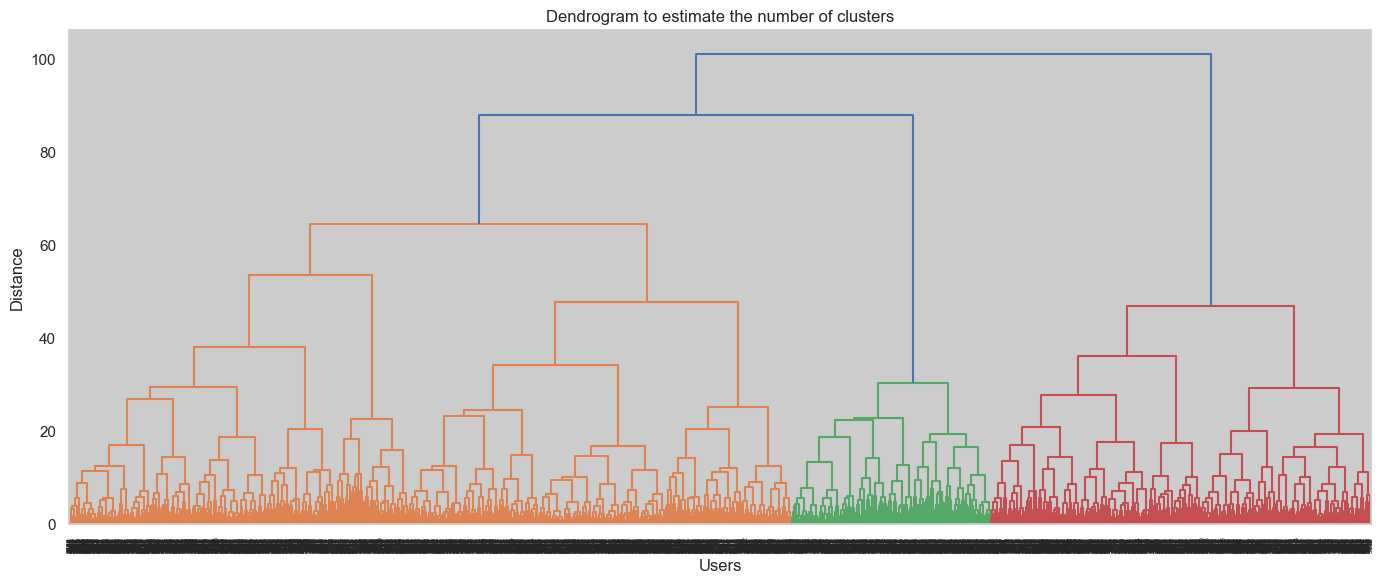

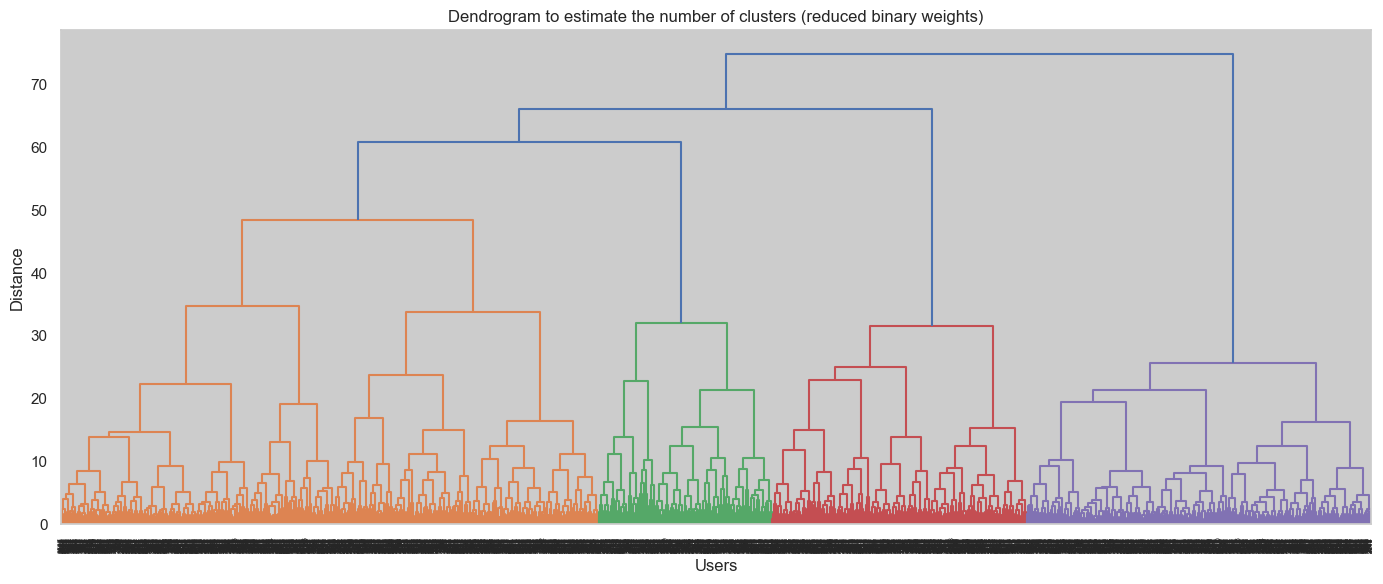

In [31]:
# Copiamos el dataframe con las mismas variables
cluster_data = mf[features].copy()
cluster_data_reduced = mf[features].copy()

# Definimos las variables binarias
binary_features = ['Partner', 'Promo_friends', 'Group_visits', 'Near_Location']

# Reducción de peso de variables binarias
# cluster_data_reduced[binary_features] = cluster_data_reduced[binary_features] * 0.25

# Reescalamos todas las variables (incluyendo las binarias porque K-means usa distancias)
scaler = StandardScaler()
cluster_scaled = scaler.fit_transform(cluster_data)

# Escalar primero
cluster_scaled_reduced = scaler.fit_transform(cluster_data.copy())

# Aplicar reducción de pesos *después* de escalar
for i, feature in enumerate(features):
    if feature in binary_features:
        cluster_scaled_reduced[:, i] *= 0.25

# Crear matriz de enlaces para el dendrograma
linked = linkage(cluster_scaled, method='ward')
linked_reduced = linkage(cluster_scaled_reduced, method='ward') 

# Trazar dendrograma
plt.figure(figsize=(14, 6))
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=False)
plt.title('Dendrograma para estimar número de clústeres')
plt.xlabel('Usuarios')
plt.ylabel('Distancia')
plt.grid(True)
plt.tight_layout()
plt.show()

# Trazar dendrograma pesos reducidos
plt.figure(figsize=(14, 6))
dendrogram(linked_reduced, orientation='top', distance_sort='descending', show_leaf_counts=False)
plt.title('Dendrograma para estimar número de clústeres (pesos reducidos)')
plt.xlabel('Usuarios')
plt.ylabel('Distancia')
plt.grid(True)
plt.tight_layout()
plt.show()

/Users/stephanethions/Desktop/TripleTen/GitHub Projects/customer-churn-prediction-ml/sprint_13_ML/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/stephanethions/Desktop/TripleTen/GitHub Projects/customer-churn-prediction-ml/sprint_13_ML/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,Age,Lifetime,Contract_period,Avg_additional_charges_total,Avg_class_frequency_total,Near_Location,Partner,Promo_friends,Group_visits
cluster,,,,,,,,,
0,30.31,12.56,5.66,165.49,2.26,0.95,0.48,0.25,0.43
1,28.62,2.44,2.72,140.85,1.76,1.00,0.23,0.06,0.00
2,28.67,2.75,2.94,137.04,1.76,0.00,0.49,0.07,0.23
3,29.54,3.58,7.97,153.07,1.93,1.00,0.97,0.84,0.51
4,29.39,2.82,3.59,146.47,1.91,1.00,0.15,0.09,1.00


,Age,Lifetime,Contract_period,Avg_additional_charges_total,Avg_class_frequency_total,Near_Location,Partner,Promo_friends,Group_visits
cluster_reduced,,,,,,,,,
0,26.27,1.63,1.94,104.23,1.32,0.78,0.39,0.22,0.32
1,31.32,3.15,2.47,95.86,2.30,0.82,0.42,0.25,0.40
2,29.67,3.15,2.97,272.80,1.92,0.85,0.45,0.29,0.38
3,29.63,12.38,5.39,149.58,2.08,0.88,0.51,0.35,0.48
4,29.91,3.66,11.98,158.49,2.00,0.94,0.72,0.48,0.54


,cluster,num_users,churn_rate
0,0,330,0.00
1,1,1132,42.49
2,2,598,40.97
3,3,1155,12.29
4,4,785,24.59


,cluster_reduced,num_users,churn_rate
0,0,1106,68.81
1,1,982,16.50
2,2,689,16.69
3,3,385,0.26
4,4,838,2.63


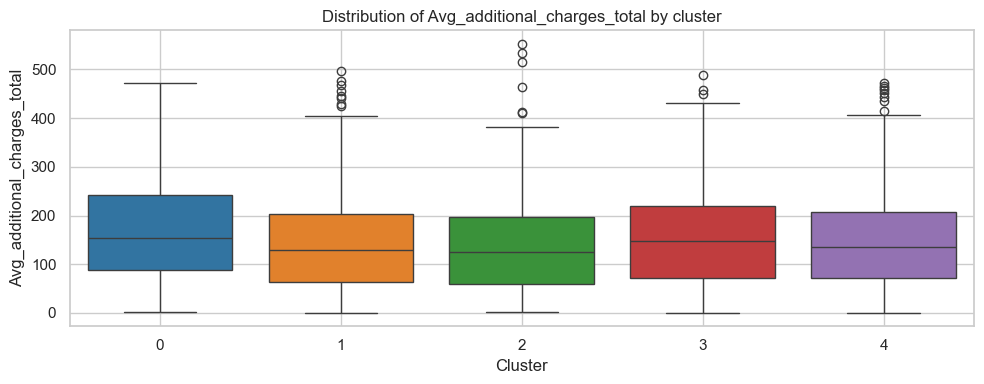

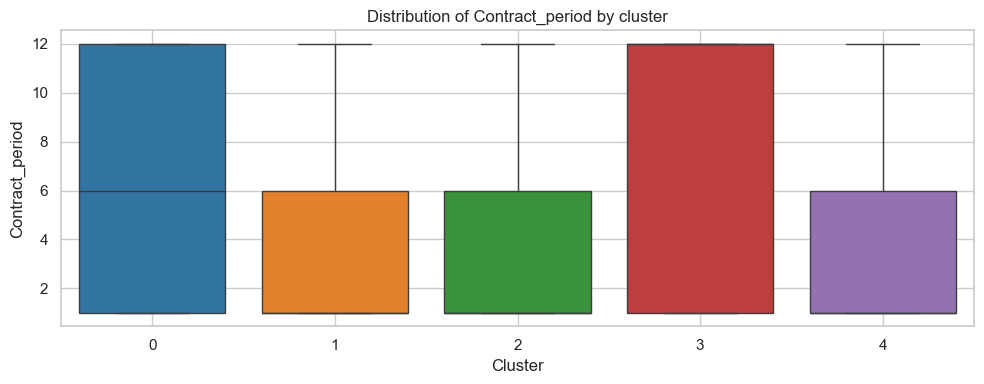

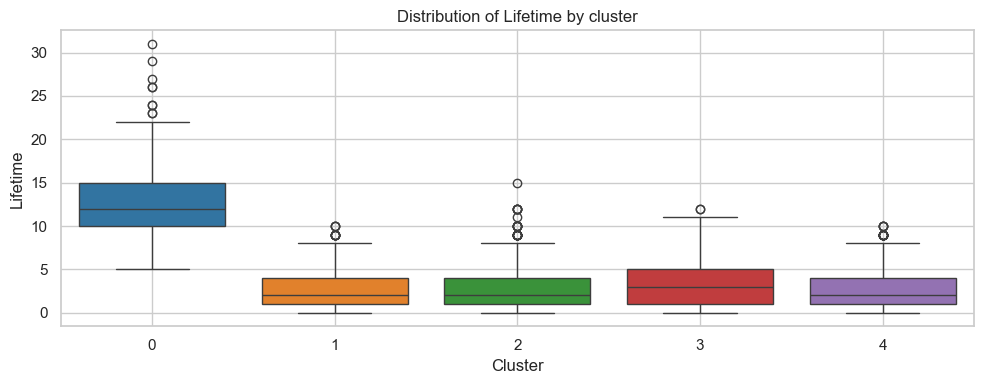

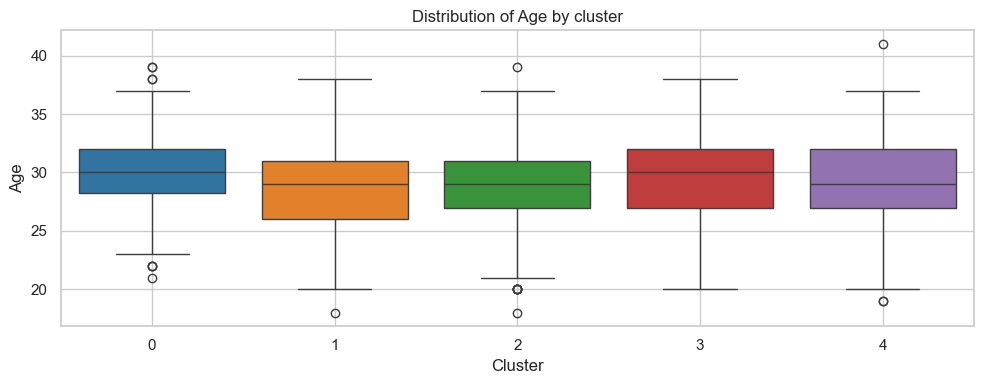

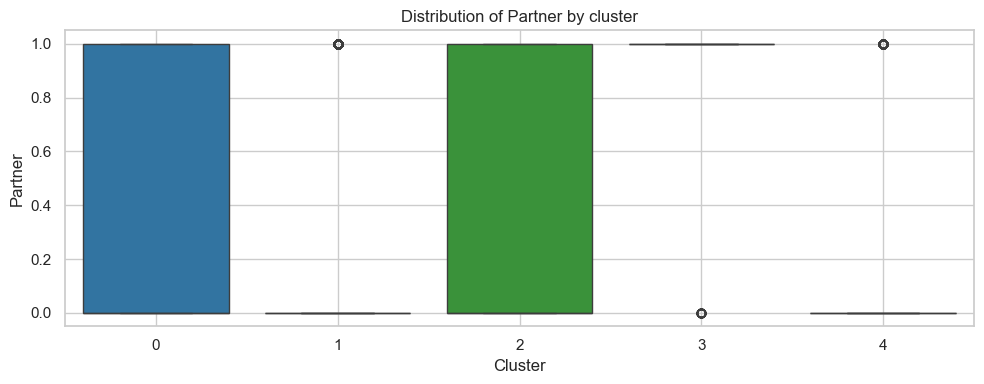

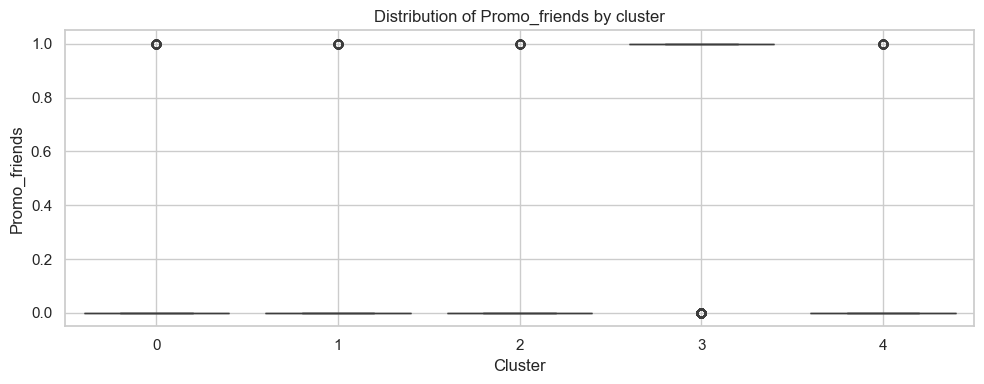

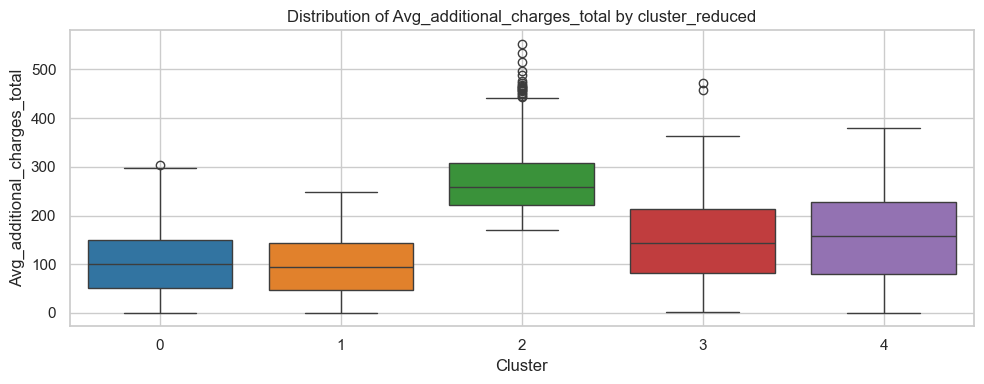

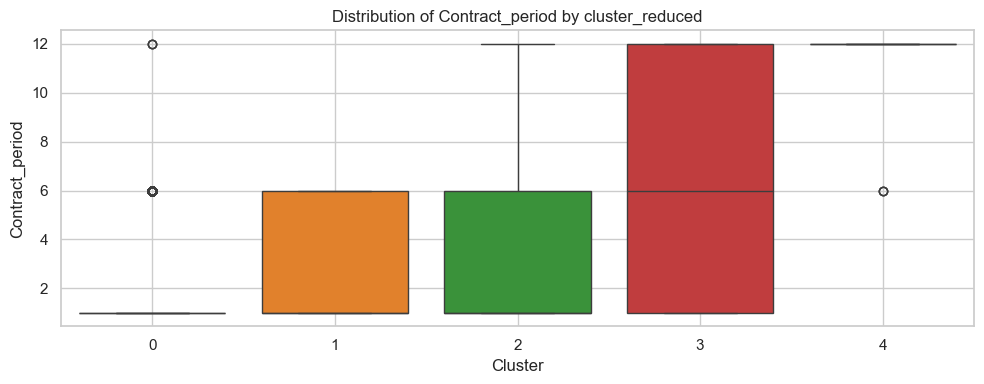

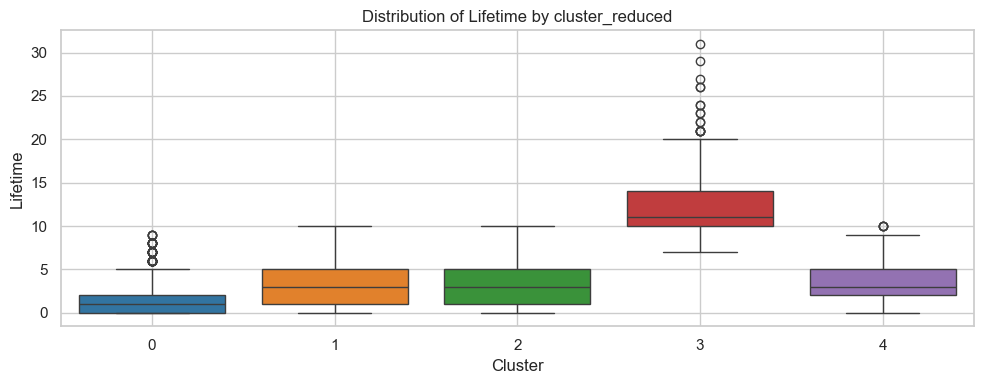

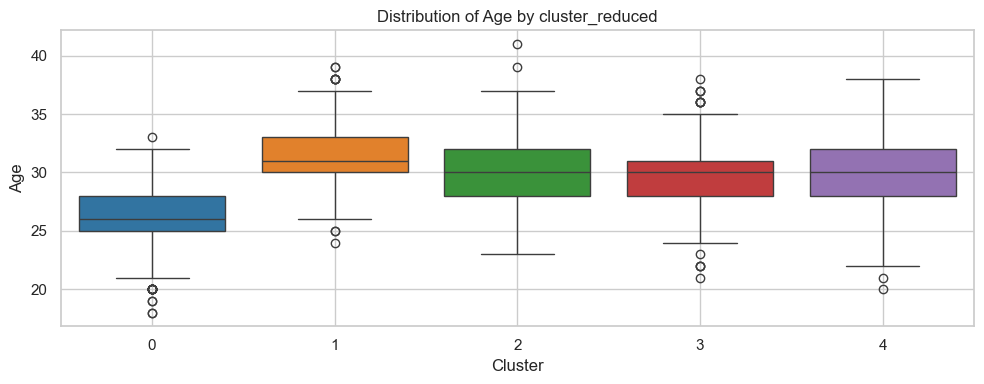

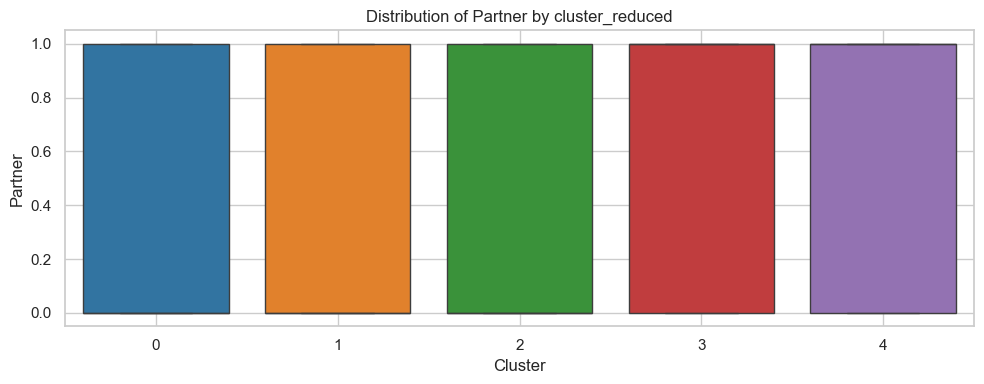

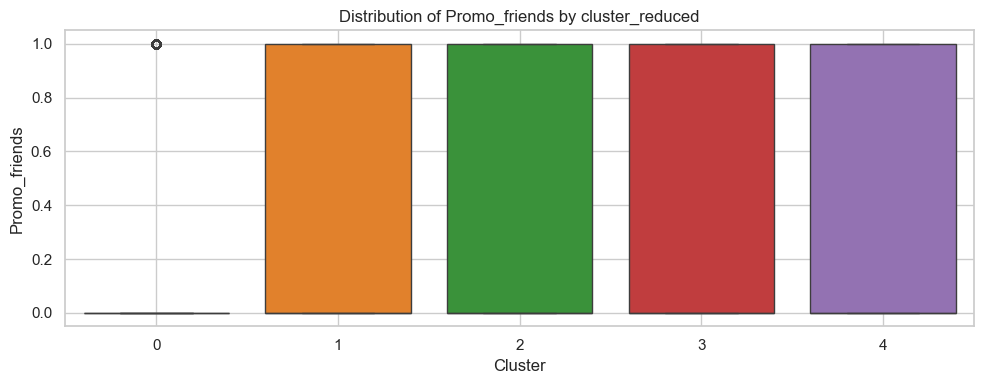

In [40]:
# 1. Train KMeans
kmeans = KMeans(n_clusters=5, random_state=42)
mf['cluster'] = kmeans.fit_predict(cluster_scaled)
mf['cluster_reduced'] = KMeans(n_clusters=5, random_state=42).fit_predict(cluster_scaled_reduced)

# 2. View feature averages by cluster
cluster_means = mf.groupby('cluster')[features].mean().round(2)
display(cluster_means)
print()

cluster_means_reduced = mf.groupby('cluster_reduced')[features].mean().round(2)
display(cluster_means_reduced)

# 3. Calculate cluster size and churn rate
cluster_summary = mf.groupby('cluster').agg({
    'Churn': ['count', 'mean']
}).reset_index()

cluster_summary_reduced = mf.groupby('cluster_reduced').agg({
    'Churn': ['count', 'mean']
}).reset_index()

# Rename columns
cluster_summary.columns = ['cluster', 'num_users', 'churn_rate']
cluster_summary_reduced.columns = ['cluster_reduced', 'num_users', 'churn_rate']

# Convert churn rate to percentage
cluster_summary['churn_rate'] = (cluster_summary['churn_rate'] * 100).round(2)
cluster_summary_reduced['churn_rate'] = (cluster_summary_reduced['churn_rate'] * 100).round(2)

# Display summary tables
display(cluster_summary)
print()
display(cluster_summary_reduced)

# 4. Function to plot feature distributions by cluster
def plot_feature_by_cluster(df, cluster_type, feature):
    plt.figure(figsize=(10, 4))
    sns.boxplot(
        data=df,
        x=cluster_type,
        y=feature,
        hue=cluster_type,
        palette='tab10',
        legend=False
    )
    plt.title(f'Distribution of {feature} by {cluster_type}')
    plt.xlabel('Cluster')
    plt.ylabel(feature)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 5. Plot the most influential features from the classification models
important_features = [
    'Avg_additional_charges_total',
    'Contract_period',
    'Lifetime',
    'Age', 
    'Partner', 
    'Promo_friends'
]

for feature in important_features:
    plot_feature_by_cluster(mf, 'cluster', feature)

for feature in important_features: 
    plot_feature_by_cluster(mf, 'cluster_reduced', feature)

In [33]:
# Evaluate clustering quality using the Silhouette Score
score = silhouette_score(cluster_scaled, mf['cluster'])
print(f'Silhouette Score: {score:.3f}')

# Evaluate clustering quality after reducing the weight of binary variables
reduced_score = silhouette_score(cluster_scaled_reduced, mf['cluster_reduced'])
print("Silhouette Score (reduced binary weights):", round(reduced_score, 3))

Silhouette Score: 0.162
Silhouette Score (reduced binary weights): 0.174


Silhouette Score (Gower + K-Medoids): 0.192


,Age,Lifetime,Contract_period,Avg_additional_charges_total,Avg_class_frequency_total,Near_Location,Partner,Promo_friends,Group_visits
cluster,,,,,,,,,
0,29.71,3.82,3.21,204.33,1.93,0.81,0.00,0.08,0.00
1,27.65,2.60,2.09,67.20,1.61,0.79,0.00,0.07,0.00
2,30.09,4.57,8.43,155.62,1.90,0.96,0.98,0.92,0.47
3,28.42,3.22,2.80,141.96,1.91,0.72,1.00,0.21,0.23
4,29.47,3.91,5.19,148.37,1.94,0.90,0.19,0.11,1.00


,cluster,num_users,churn_rate
0,0,668,25.75
1,1,547,60.69
2,2,926,5.94
3,3,842,36.58
4,4,1017,19.08


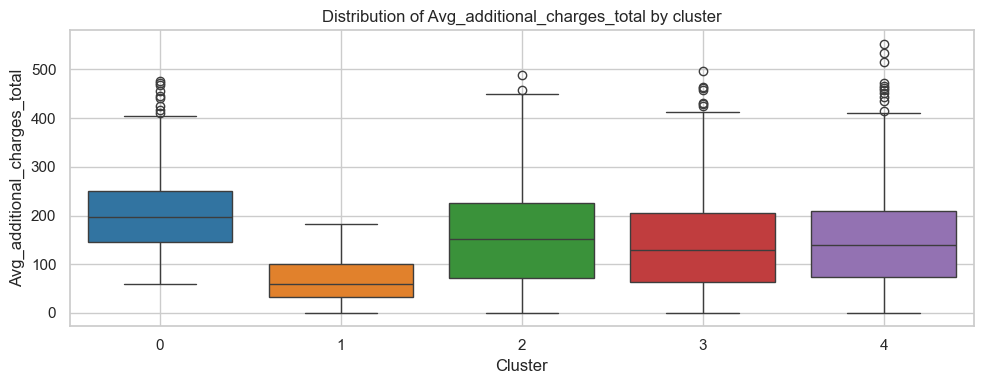

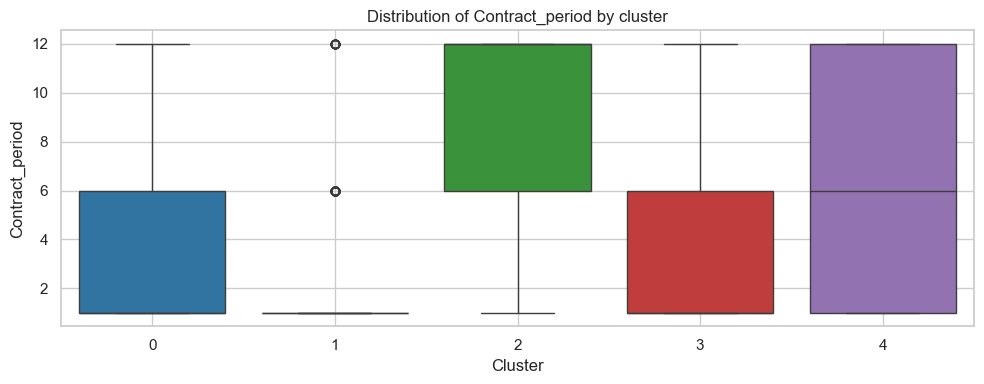

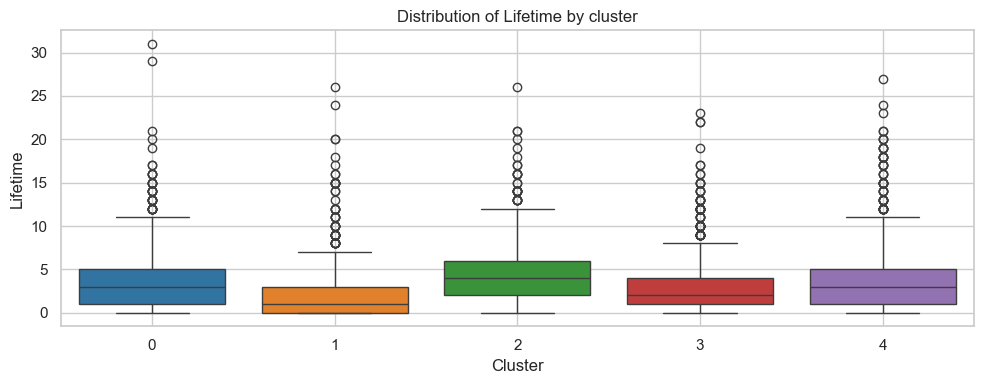

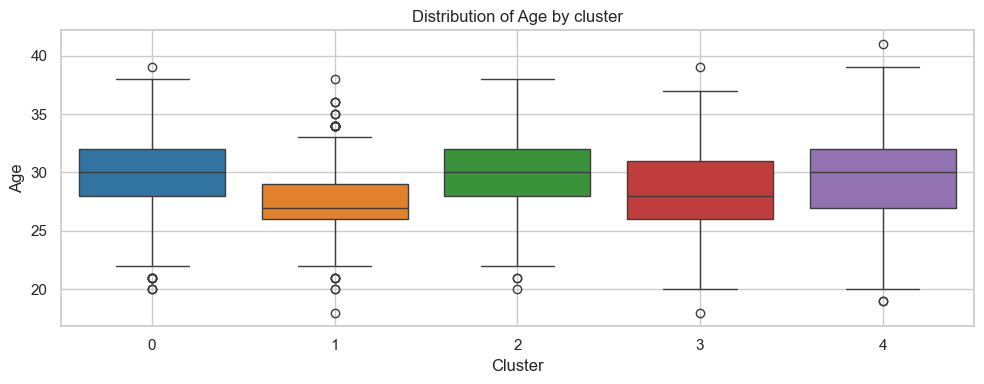

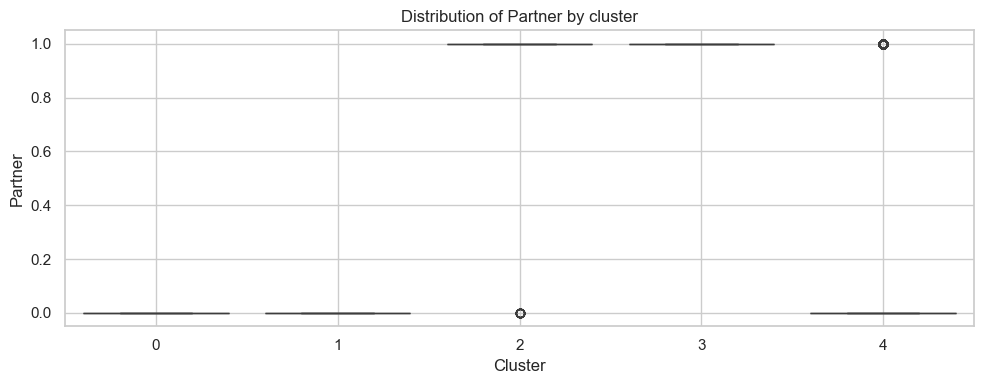

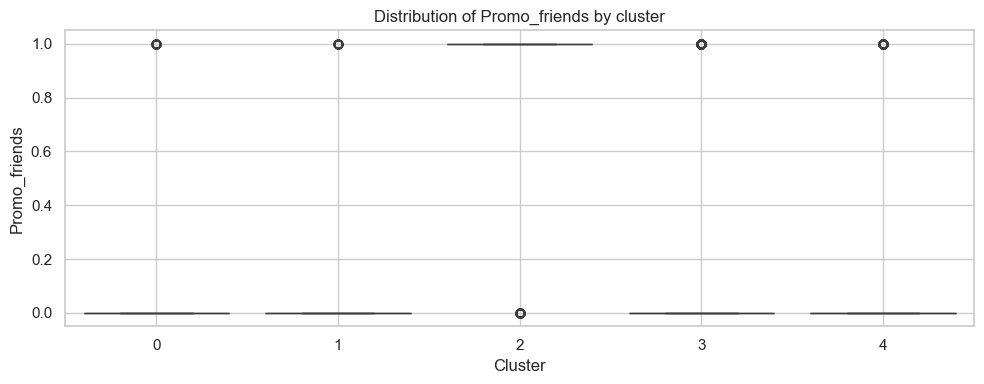

In [41]:
# Compute the Gower distance matrix
# Gower distance is suitable for mixed data types (numerical + binary features)
# and provides a more appropriate similarity measure than Euclidean distance
gower_dist = gower.gower_matrix(cluster_data)

# Apply K-Medoids using the precomputed Gower distance matrix
# K-Medoids is more robust than K-Means when working with arbitrary distance metrics
kmedoids = KMedoids(n_clusters=5, metric='precomputed', random_state=42)
mf['cluster'] = kmedoids.fit_predict(gower_dist)

# Evaluate clustering quality using the Silhouette Score
# Since distances are precomputed, the metric must be set accordingly
sil_score = silhouette_score(gower_dist, mf['cluster'], metric='precomputed')
print(f"Silhouette Score (Gower + K-Medoids): {sil_score:.3f}")

# Compute average feature values per cluster
cluster_means = mf.groupby('cluster')[features].mean().round(2)
display(cluster_means)

# Compute cluster size and churn rate
cluster_summary = mf.groupby('cluster').agg({
    'Churn': ['count', 'mean']
}).reset_index()

# Rename columns for clarity
cluster_summary.columns = ['cluster', 'num_users', 'churn_rate']

# Convert churn rate to percentage
cluster_summary['churn_rate'] = (cluster_summary['churn_rate'] * 100).round(2)
display(cluster_summary)

# Visualize the most influential features identified in the classification models
important_features = [
    'Avg_additional_charges_total',
    'Contract_period',
    'Lifetime',
    'Age', 
    'Partner',
    'Promo_friends'
]

for feature in important_features:
    plot_feature_by_cluster(mf, 'cluster', feature)

#### 🧠 Comparative Conclusion of Clustering Techniques

During the segmentation process, three different approaches were explored to group users based on their behavioral and demographic characteristics. Each method was evaluated using the Silhouette Score to assess internal cohesion and separation between clusters. The key findings are summarized below:

##### 1. KMeans with all standardized variables
- **Description:** Both continuous and binary variables were included and standardized using `StandardScaler`.
- **Result:** The algorithm produced clusters heavily influenced by binary variables such as `Promo_friends` and `Near_Location`, leading to clusters dominated by specific binary patterns.
- **Silhouette score:** `0.162`
- **Limitation:** Excessive dominance of binary variables in distance calculations, potentially masking more nuanced behavioral patterns.

##### 2. KMeans with reduced binary weights (0.25)
- **Description:** The influence of binary variables was reduced *after scaling*, attenuating their impact on Euclidean distance.
- **Result:** Clusters exhibited greater internal variation in binary features and a more balanced behavioral profile.
- **Silhouette score:** `0.174`
- **Advantage:** Improved balance between feature types, enabling the detection of richer behavioral structures.

##### 3. KMedoids with Gower distance
- **Description:** A distance metric specifically designed for mixed data types was applied, handling continuous and categorical variables without arbitrary scaling decisions.
- **Result:** The clustering achieved improved cohesion and separation compared to both KMeans approaches.
- **Silhouette score:** `0.192`
- **Advantage:** More natural for mixed datasets and less sensitive to scaling assumptions, resulting in more coherent and interpretable segments.


#### 🚧 Opportunity for Improvement: Behavior-Driven Clustering

Although each technique provided valuable insights, none fully captured a segmentation driven purely by user behavior. A key challenge observed across methods is the disproportionate influence of binary variables in distance-based clustering.

To address this, a refined strategy is proposed:

> **Decouple clustering from profiling.**

**Proposed approach:**
- **Perform clustering exclusively on standardized continuous variables**, which better represent user behavior (attendance frequency, tenure, spending patterns, age).
- **Profile clusters afterward using binary variables**, analyzing how attributes such as partnerships, referrals, and group participation distribute across behavior-driven segments.

This approach aims to define clusters based primarily on behavioral similarity rather than binary flags, reducing structural bias introduced by dummy variables and enabling more natural, action-oriented segmentation.

In [42]:
# Select only continuous features for behavior-driven clustering
continuous_features = [
    'Age',
    'Lifetime',
    'Contract_period',
    'Avg_additional_charges_total',
    'Avg_class_frequency_total'
]

# Standardize continuous variables
# Scaling is required for distance-based algorithms like KMeans
scaler = StandardScaler()
X_scaled = scaler.fit_transform(mf[continuous_features])

# Apply KMeans clustering using only continuous features
kmeans = KMeans(n_clusters=5, random_state=42)
mf['cluster_continuous'] = kmeans.fit_predict(X_scaled)

# Define binary features for post-clustering profiling
binary_features = ['Near_Location', 'Partner', 'Promo_friends', 'Group_visits']

# Compute average continuous feature values per cluster
continuous_profile = (
    mf.groupby('cluster_continuous')[continuous_features]
      .mean()
      .round(2)
)

# Compute distribution of binary features per cluster
binary_profile = (
    mf.groupby('cluster_continuous')[binary_features]
      .mean()
      .round(2)
)

# Display cluster profiles
display(continuous_profile)
display(binary_profile)

# Evaluate clustering quality using the Silhouette Score
silhouette = silhouette_score(X_scaled, mf['cluster_continuous'])
print(f'Silhouette Score (continuous features only): {silhouette:.3f}')

/Users/stephanethions/Desktop/TripleTen/GitHub Projects/customer-churn-prediction-ml/sprint_13_ML/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,Age,Lifetime,Contract_period,Avg_additional_charges_total,Avg_class_frequency_total
cluster_continuous,,,,,
0,29.68,3.17,2.96,271.80,1.94
1,29.61,12.40,5.39,149.17,2.07
2,29.92,3.67,11.99,158.52,2.01
3,31.34,3.13,2.47,94.85,2.28
4,26.24,1.63,1.95,104.68,1.32


,Near_Location,Partner,Promo_friends,Group_visits
cluster_continuous,,,,
0,0.85,0.44,0.29,0.38
1,0.88,0.51,0.35,0.48
2,0.94,0.72,0.48,0.54
3,0.82,0.42,0.25,0.40
4,0.78,0.39,0.22,0.32


Silhouette Score (continuous features only): 0.188


#### 📊 Conclusion of the Clustering Analysis

After applying multiple segmentation approaches — including **KMeans**, **KMeans with reduced binary feature weights**, **KMeans using only continuous variables**, and **K-Medoids with Gower distance** — the results consistently show **low Silhouette Scores across all methods (ranging approximately from 0.16 to 0.19)**.

This outcome suggests that **the dataset does not contain strongly separable, naturally well-defined clusters**. Even after reducing the influence of binary variables or restricting the clustering process exclusively to continuous behavioral features, the resulting groups exhibit **substantial overlap in their average profiles**.

These findings indicate that user differences within the gym population are **gradual rather than discrete**. In other words, customers do not fall into sharply distinct behavioral segments, but instead lie along **continuous spectra of engagement, tenure, spending, and attendance patterns**.

From an analytical perspective, this is not a methodological failure but rather an important insight into the nature of the data: the available features, while informative for **prediction and retention modeling**, do not produce clear-cut behavioral clusters when evaluated through distance-based unsupervised learning.

As a result, clustering outputs should be interpreted as **exploratory and descriptive tools**, useful for **profiling tendencies and supporting strategic intuition**, rather than as strict segmentation boundaries. This reinforces the value of combining clustering insights with **supervised models and business-driven rules** when designing customer retention strategies.

---

### 🧠 Conclusions on Customer Clusters and Churn Behavior

The clustering analysis using **Gower distance combined with K-Medoids** allowed for a more balanced segmentation between binary and continuous variables. Although the resulting **Silhouette Score of 0.192** indicates a **moderate level of cluster separation**, the identified groups reflect **patterns that are consistent with previous exploratory analysis and predictive modeling results**.

- **Cluster 1** shows the **highest churn rate (60.7%)**. This group is characterized by very short contracts, low customer lifetime, and the lowest additional spending. Social engagement variables (`Promo_friends`, `Group_visits`) are close to zero, suggesting **low social connection to the service**. In addition, almost none of these users joined through corporate partnerships (`Partner = 0`), reinforcing a **high-risk profile with weak ties to the gym ecosystem**.

- **Cluster 2** stands out as the **most loyal segment**, with a churn rate of only **5.9%**. Users in this group have long contracts, high tenure, and the strongest social and institutional connections: **92% joined through friend referrals**, **98% through partner companies**, and **47% participate in group activities**. These social and corporate access factors appear to play a critical role in retention, reinforcing findings from the regression models.

- **Cluster 3** exhibits a **moderate churn rate (36.6%)** and is defined by the fact that **all users joined through partner companies (`Partner = 1.00`)**, although participation in other social mechanisms such as friend promotions or group visits is lower. This suggests that **corporate access alone can support retention but does not guarantee long-term loyalty without additional engagement drivers**.

- **Cluster 4**, with a churn rate of **19.1%**, groups users who **consistently attend group activities (100%)** and mostly live near a gym location (`Near_Location = 0.90`). Even though not all users joined through partners or friend referrals, the **group-based dynamic appears to be a key retention factor** for this segment.

- **Cluster 0**, with a churn rate of **25.8%**, represents an intermediate profile. Most users did not join through promotions or corporate partnerships and do not participate in group activities. This segment reflects **low social and institutional attachment**, presenting clear opportunities for targeted engagement and activation strategies.

- Compared to earlier analyses, a **clearer role of the `Age` variable emerges** in this segmentation. Clusters with lower churn tend to have a **higher average age** (e.g., **30.09 years in Cluster 2 vs. 27.65 years in Cluster 1**), which may be associated with greater stability, routine formation, or long-term commitment to the service.

---

##### 🎯 **Overall Conclusion**

Despite the moderate Silhouette Score, the resulting clusters provide **actionable insights that are coherent with the EDA and regression-based findings**. Social and institutional variables — such as **joining through partner companies (`Partner`)**, **friend referrals (`Promo_friends`)**, and **group participation (`Group_visits`)** — consistently emerge as **key drivers of customer retention**.

Therefore, this segmentation analysis is **valuable for designing targeted retention strategies and engagement initiatives**, even if the mathematical separation between clusters is not perfectly defined.

## 🧭 Step 5: Final Conclusions and Strategic Recommendations for Customer Retention

Based on the churn analysis and customer clustering results, we identified distinct user segments with different levels of engagement, commitment, and risk of cancellation. These insights enable the design of targeted strategies aimed at improving retention and optimizing marketing and operational efforts.

### 1. Strengthen and Scale Social and Group-Based Programs
Clusters with the lowest churn rates show a high presence of users enrolled through corporate partnerships (`Partner`), friend referrals (`Promo_friends`), and group participation (`Group_visits`).

**Recommendation:**
- Continue investing in socially driven acquisition and retention strategies, expanding referral programs, corporate partnerships, and group-based initiatives.
- Reinforce these dynamics with ongoing incentives and in-platform visibility (e.g., group rewards, loyalty levels, or shared achievements).

---

### 2. Promote Longer-Term Contracts
Users with longer contract periods and greater tenure consistently show lower churn rates.

**Recommendation:**
- Introduce incentives for long-term commitments (e.g., “12-month contract with 2 months free”).
- Clearly communicate cost savings and benefits when comparing short-term versus long-term contracts during renewal moments.

---

### 3. Reactivate Low-Engagement Users Early
High-churn clusters are characterized by low attendance frequency, short customer lifetime, and limited social involvement.

**Recommendation:**
- Detect early signs of inactivity and trigger personalized reactivation campaigns (e.g., “We miss you! Come back this week and get a reward”).
- Introduce personalized challenges or routines to encourage habit formation (e.g., 7-day or 14-day attendance challenges).

---

### 4. Apply Cluster-Based Marketing Segmentation
Cluster segmentation enables more precise messaging, incentives, and experiences tailored to each user profile.

**Recommendation:**
- Use clusters as the foundation for targeted campaigns (e.g., **retention-focused campaigns for Cluster 1**, which shows the highest churn, and **engagement-building campaigns for Cluster 3**, where users remain recoverable).
- Track performance by cluster to optimize resource allocation and continuously personalize the customer experience.

---

### 📌 Additional Notes on the `Age` Variable

Although age differences across clusters appear relatively modest (generally ranging between 26 and 31 years), **statistical testing confirmed that these differences are significant**. Clusters with lower churn tend to include **slightly older users**, which may be associated with greater stability, routine formation, or long-term commitment to the service.

This finding complements earlier analyses and reinforces the idea that **demographic context should be considered alongside behavioral and social factors** when designing retention and loyalty strategies.